In [1]:
import random
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [2]:
import matplotlib.pyplot as plt
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [3]:
CONTEXT = 8
BATCH_SIZE = 256

In [4]:
f = open('names.txt', 'r', encoding='utf-8')
names = f.read().split("\n")
f.close()

names = ["."*CONTEXT + name + "." for name in names]
names[:5]

['........emma.',
 '........olivia.',
 '........ava.',
 '........isabella.',
 '........sophia.']

In [5]:
CHARS = sorted(list(set("".join(names))))
stoi = {ch: i for i, ch in enumerate(CHARS)}
itos = {i: ch for i, ch in enumerate(CHARS)}

text = ".hello.world."
"".join([itos[i] for i in [stoi[ch] for ch in text]])

'.hello.world.'

In [6]:
class NameDataset(Dataset):
    def __init__(self, names):
        self.x = []
        self.y = []
        for name in names:
            for i in range(CONTEXT, len(name)):
                self.x.append([stoi[ch] for ch in name[i-CONTEXT:i]])
                self.y.append(stoi[name[i]])
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)
        
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [7]:
split = int(len(names)*0.9)
random.seed(42)
random.shuffle(names)
train_data = NameDataset(names[:split])
val_data = NameDataset(names[split:])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=RandomSampler(train_data, replacement=True, num_samples=BATCH_SIZE))
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

len(train_loader), len(val_loader)

(1, 90)

In [8]:
class ConvNet(nn.Module):
    def __init__(self, emb_dim=32, conv_dim=64, lin_dims=[128, 256]):
        super().__init__()
        self.num_layers = int(np.log2(CONTEXT))  # CONTEXT = 8
        self.stats = {}
        self.embedding = nn.Embedding(len(CHARS), emb_dim)
        self.pos_embedding = nn.Embedding(CONTEXT, emb_dim)
        self.pos_embedding.weight.data *= 0.1
        self.in_proj = nn.Conv1d(emb_dim, conv_dim, kernel_size=1)
        
        self.conv_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        self.compress_layers = nn.ModuleList()
        self.dropout = nn.Dropout(0.2)
        
        for _ in range(self.num_layers):
            self.conv_layers.append(nn.Conv1d(conv_dim, lin_dims[0], kernel_size=2, stride=2))
            self.linear_layers.append(nn.Conv1d(lin_dims[0], lin_dims[1], kernel_size=1))
            self.norm_layers.append(nn.BatchNorm1d(lin_dims[1]))
            self.compress_layers.append(nn.Conv1d(lin_dims[1], conv_dim, kernel_size=1))
            
        self.decoder = nn.Linear(conv_dim, len(CHARS))
        
    def forward(self, x, keep_stats=False):
        # Initial embedding and dimension conversion
        x = self.embedding(x)               # (B, L, emb_dim)
        if keep_stats:
            self.stats["embedding"] = x.clone()
        pos = torch.arange(CONTEXT, device=x.device)
        x += self.pos_embedding(pos)        # (B, L, emb_dim)
        if keep_stats:
            self.stats["pos_embedding"] = x.clone()
        x = x.transpose(-1, -2)             # (B, emb_dim, L)
        
        # Project to conv_dim
        x = self.in_proj(x)                 # (B, conv_dim, L)
        if keep_stats:
            self.stats["in_proj"] = x.clone()
        for i in range(self.num_layers):
            B, C, L = x.shape
            residual = x.view(B, C, L//2, 2).sum(dim=-1)
            x = self.conv_layers[i](x)      # (B, lin_dim_0, L/2)
            if keep_stats:
                self.stats[f"conv_layer_{i}"] = x.clone()
            x = self.linear_layers[i](x)    # (B, lin_dim_1, L/2)
            if keep_stats:
                self.stats[f"lin_layer_{i}"] = x.clone()
            x = self.norm_layers[i](x)      # (B, lin_dim_1, L/2)
            if keep_stats:
                self.stats[f"norm_layer_{i}"] = x.clone()
            x = torch.tanh(x)
            if keep_stats:
                self.stats[f"tanh_{i}"] = x.clone()
            x = self.compress_layers[i](x)  # (B, conv_dim, L/2)
            if keep_stats:
                self.stats[f"comp_layer_{i}"] = x.clone()
            x += residual
            if keep_stats:
                self.stats[f"residual_{i}"] = x.clone()
            x = self.dropout(x)
        
        # Final features: (B, conv_dim, 1)
        x = x.squeeze(-1)                   # (B, conv_dim)
        x = self.decoder(x)
        if keep_stats:
            self.stats["decoder"] = x.clone()
        return x

In [9]:
def train(model, loader, steps=100, lr=1e-3):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to("cuda")
    model.train()
    stats = {"loss": [], "ratio": []}
    
    for step in range(steps):
        x, y = next(iter(loader))
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = criterion(logits, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        stats["loss"].append(loss.item())
        update_norm = torch.sqrt(sum(((lr * p.grad)**2).sum() for p in model.parameters() if p.grad is not None)).item()
        weight_norm = torch.sqrt(sum((p.data**2).sum() for p in model.parameters())).item()
        stats["ratio"].append(update_norm / weight_norm)
    return stats

In [10]:
def validate(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.to("cuda")
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to("cuda"), y.to("cuda")
            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())
    return losses

In [11]:
def makemore(model, starter=""):
    output = list(starter)
    model.to("cuda")
    model.eval()
    x_ch = (["."]*CONTEXT + list(starter))[-CONTEXT:]
    with torch.no_grad():
        while True:
            x = torch.tensor([stoi[ch] for ch in x_ch])
            x = x.to("cuda")
            x = x.unsqueeze(0)
            logits = model(x)
            probs = F.softmax(logits, dim=-1)
            y = itos[torch.multinomial(probs, num_samples=1, replacement=True).item()]
            if y == ".":
                break
            output.append(y)
            x_ch = x_ch[1:] + [y]
    return "".join(output)

In [12]:
stats = {"loss": [], "ratio": []}
model = ConvNet(emb_dim=32, conv_dim=64, lin_dims=[128, 256])
sum(p.numel() for p in model.parameters())

204475

In [21]:
train_cycles = 500

print("Training...")
for epoch in range(train_cycles):
    epoch_stats = train(model, train_loader, steps=100, lr=10**(-2))
    stats["loss"].extend(epoch_stats["loss"])
    stats["ratio"].extend(epoch_stats["ratio"])
    train_loss = sum(epoch_stats["loss"])/len(epoch_stats["loss"])
    if ((epoch+1) % (train_cycles//10)) == 0:
        val_losses = validate(model, val_loader)
        val_loss = sum(val_losses)/len(val_losses)
        print(f"Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Total Steps: {len(stats["loss"])}")

Training...
Epoch: 50, Training Loss: 2.0674, Val Loss: 2.0278, Total Steps: 55000
Epoch: 100, Training Loss: 2.0629, Val Loss: 2.0198, Total Steps: 60000
Epoch: 150, Training Loss: 2.0564, Val Loss: 2.0187, Total Steps: 65000
Epoch: 200, Training Loss: 2.0531, Val Loss: 2.0092, Total Steps: 70000
Epoch: 250, Training Loss: 2.0516, Val Loss: 2.0095, Total Steps: 75000
Epoch: 300, Training Loss: 2.0360, Val Loss: 2.0035, Total Steps: 80000
Epoch: 350, Training Loss: 2.0286, Val Loss: 2.0033, Total Steps: 85000
Epoch: 400, Training Loss: 2.0374, Val Loss: 2.0009, Total Steps: 90000
Epoch: 450, Training Loss: 2.0249, Val Loss: 1.9951, Total Steps: 95000
Epoch: 500, Training Loss: 2.0178, Val Loss: 1.9920, Total Steps: 100000


In [26]:
for _ in range(20):
    name = makemore(model)
    print(f"{name}: {("."*CONTEXT + name + ".") in names}")

cassigh: False
camelynne: False
nevah: True
keshaun: True
mehaela: False
aviee: False
caique: False
tayleigh: True
respent: False
ellina: True
kailanlee: False
knurge: False
monaeli: False
lailah: True
kaysan: True
jatoria: False
roser: False
dawlen: False
kaleyah: True
otty: False


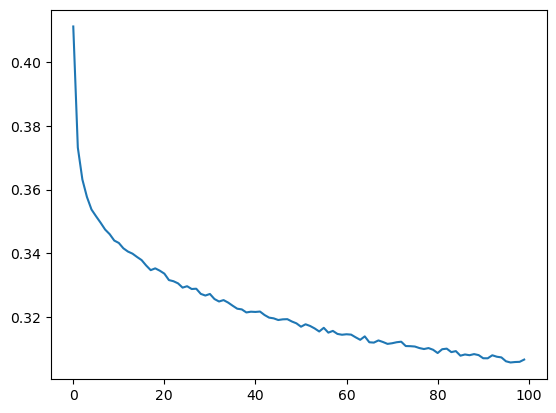

100

In [23]:
losses = torch.tensor(stats["loss"])
losses = losses.view(-1, 1000).mean(dim=1)
log_losses = losses.log10()
plt.plot(log_losses)
plt.show()
len(losses)

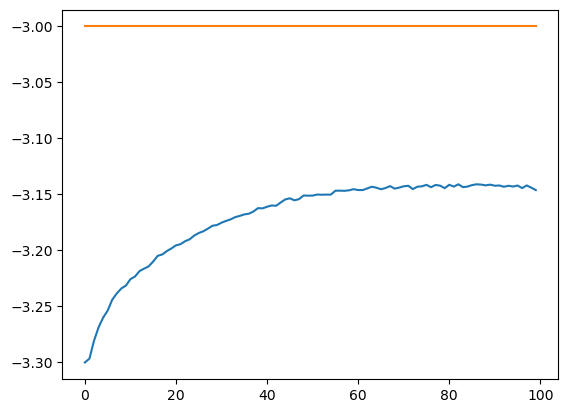

100

In [24]:
ratios = torch.tensor(stats["ratio"])
ratios = ratios.view(-1, 1000).mean(dim=1)
log_ratios = ratios.log10()
e3 = torch.ones_like(log_ratios)*(-3)
plt.plot(log_ratios)
plt.plot(e3)
plt.show()
len(ratios)

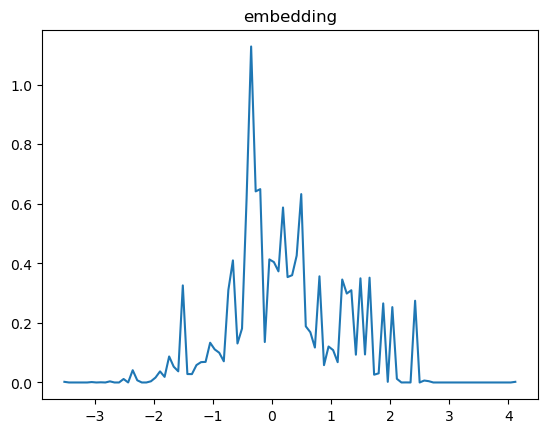

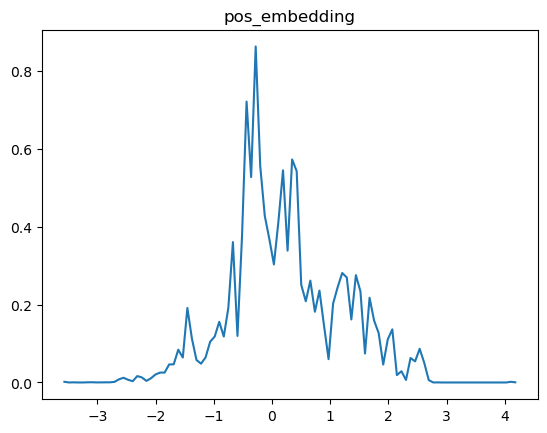

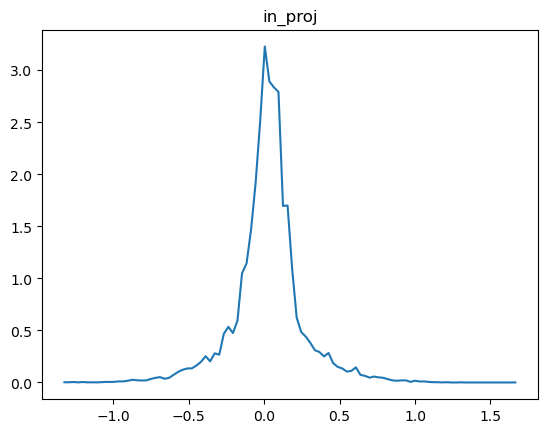

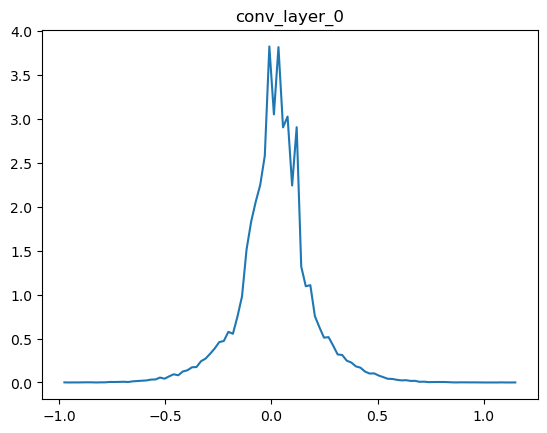

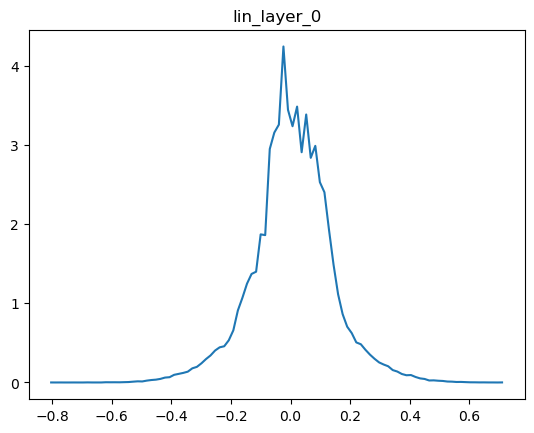

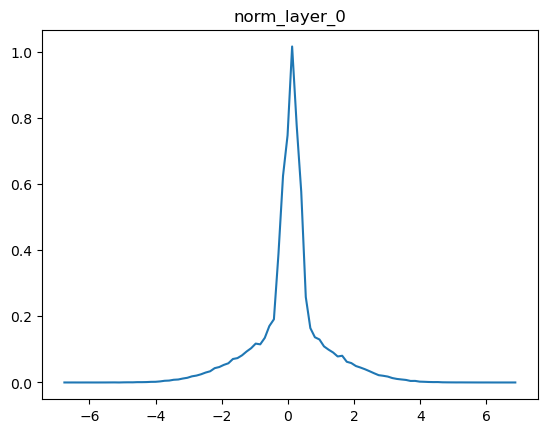

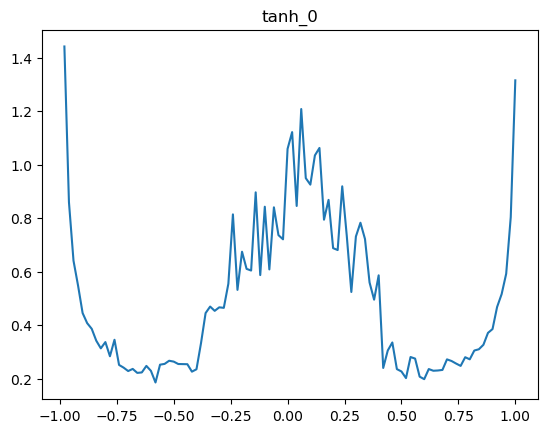

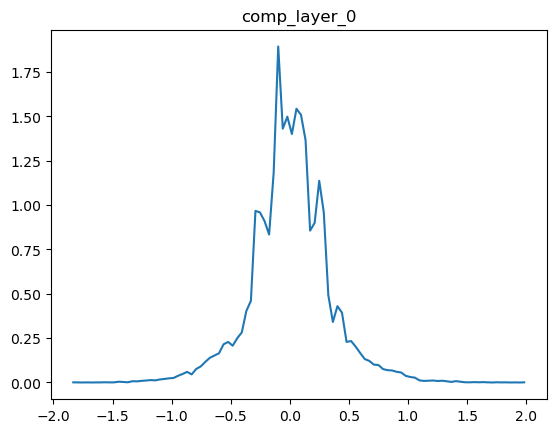

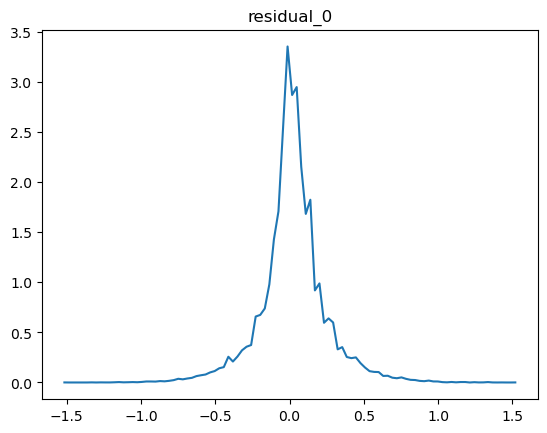

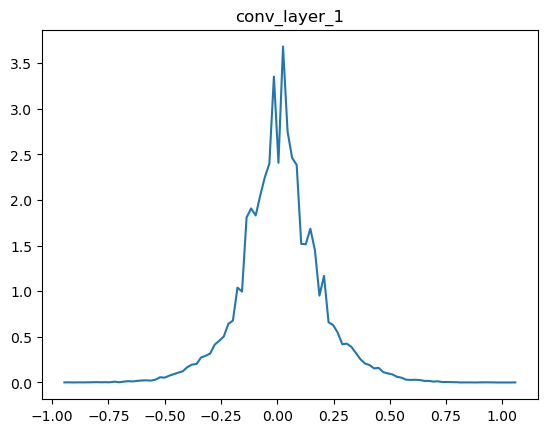

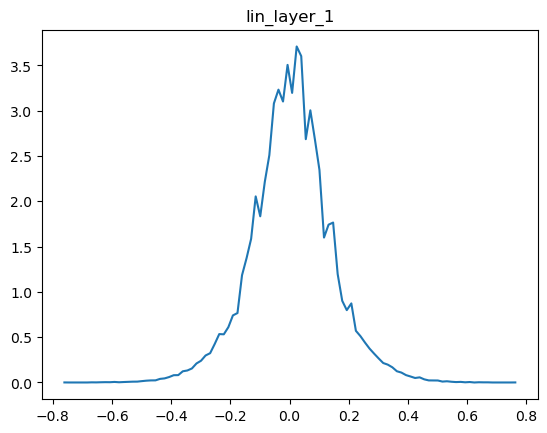

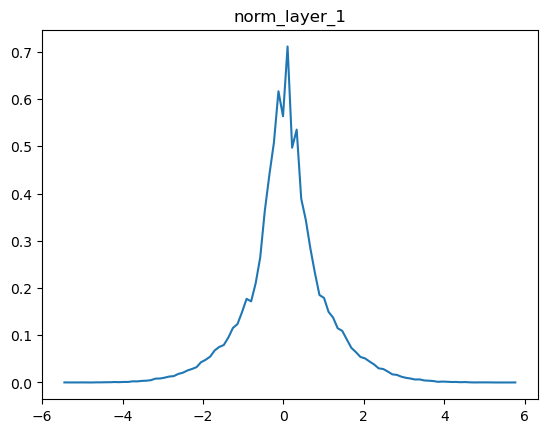

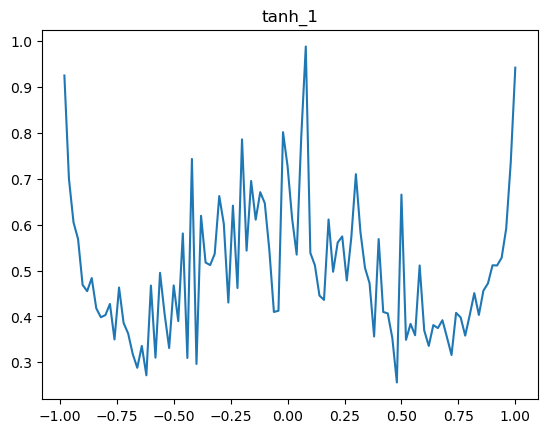

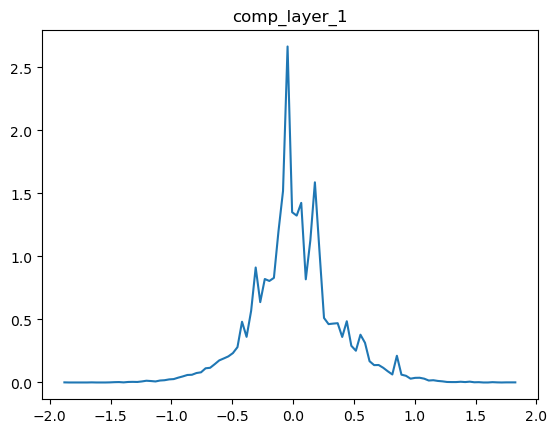

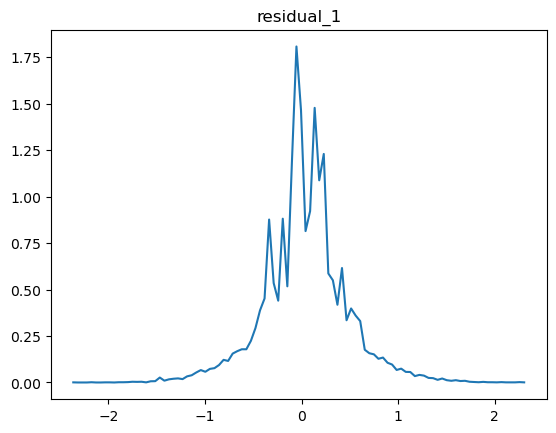

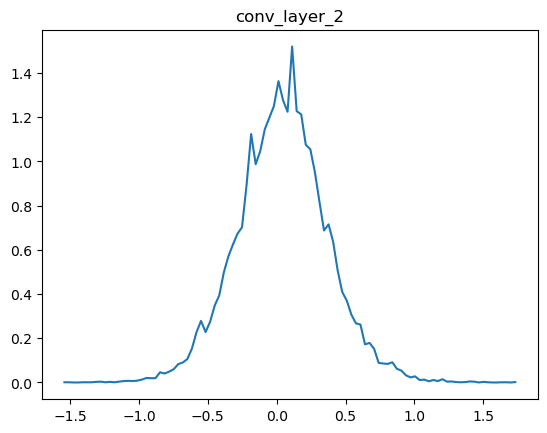

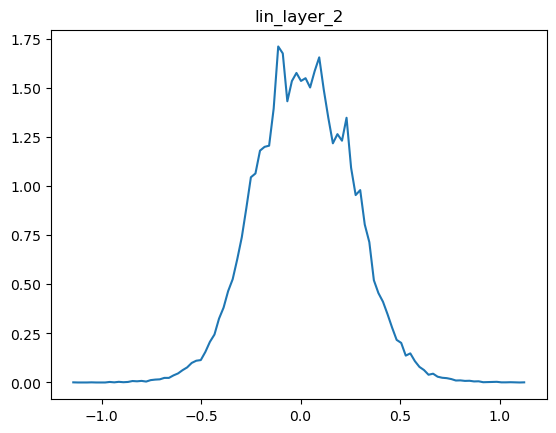

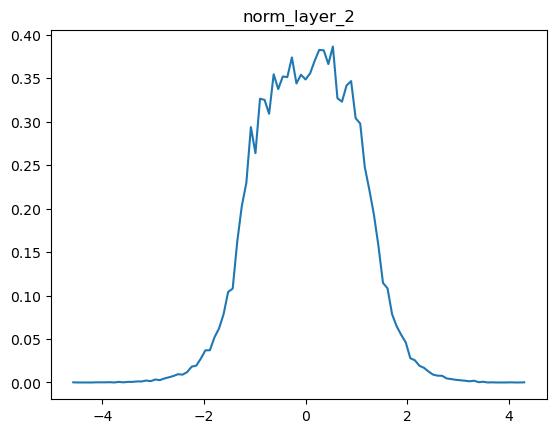

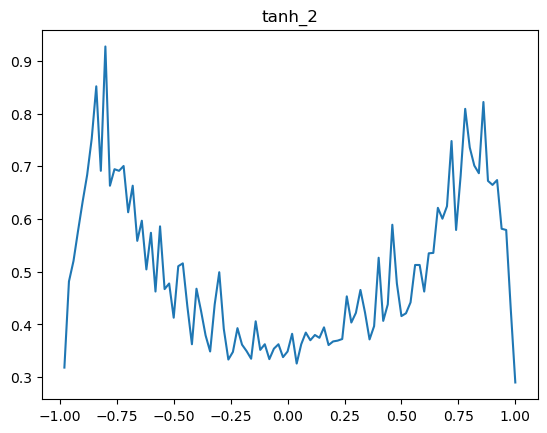

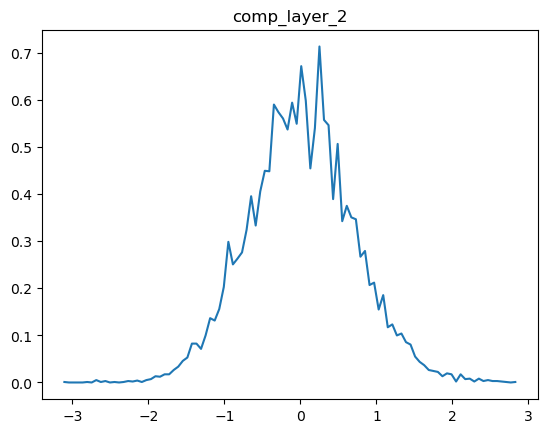

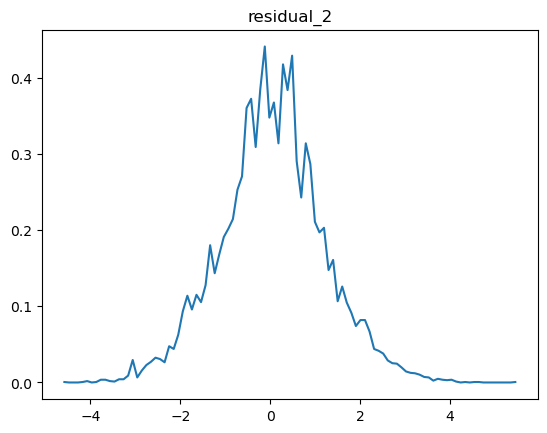

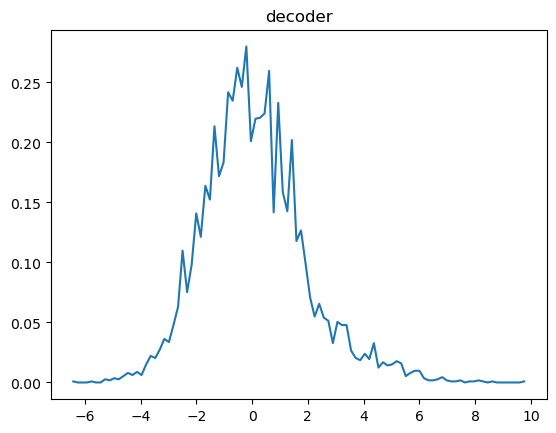

In [17]:
x, y = next(iter(train_loader))
model(x.to("cuda"), True)
out_stats = model.stats
for layer in out_stats:
    hy, hx = torch.histogram(out_stats[layer].cpu(), bins=100, density=True)
    plt.plot(hx.detach()[1:], hy.detach())
    plt.title(layer)
    plt.show()

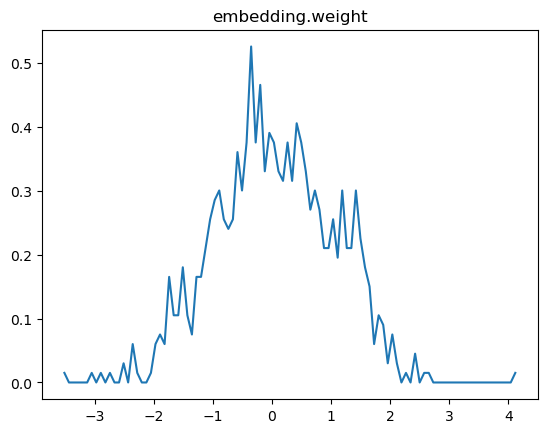

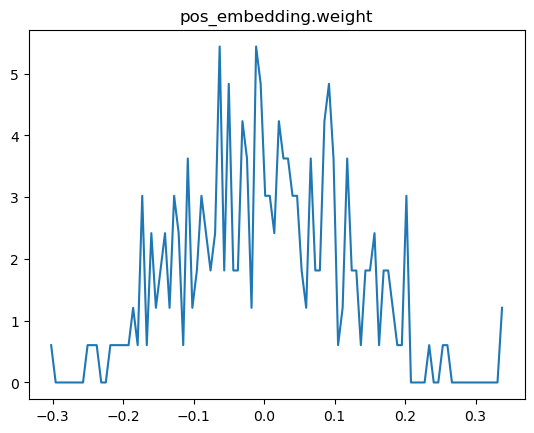

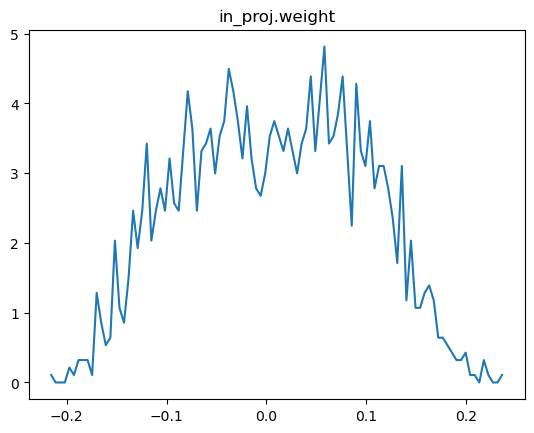

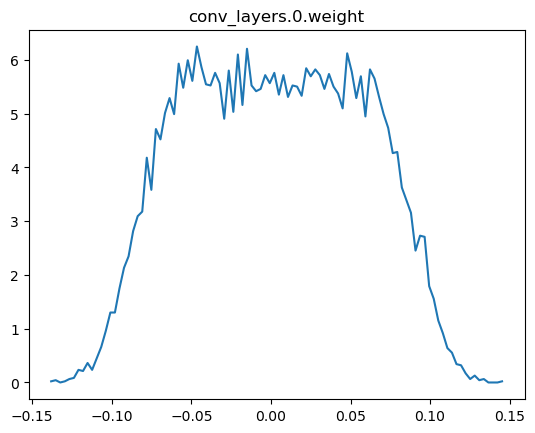

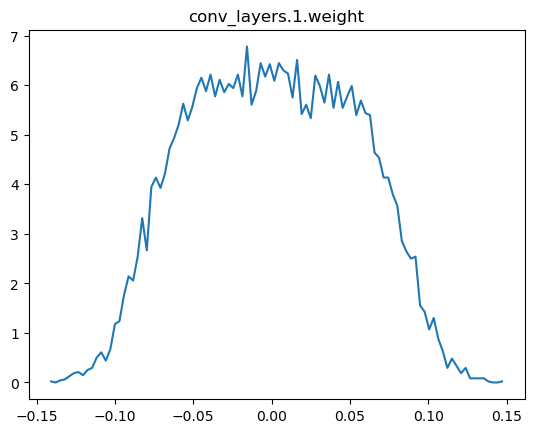

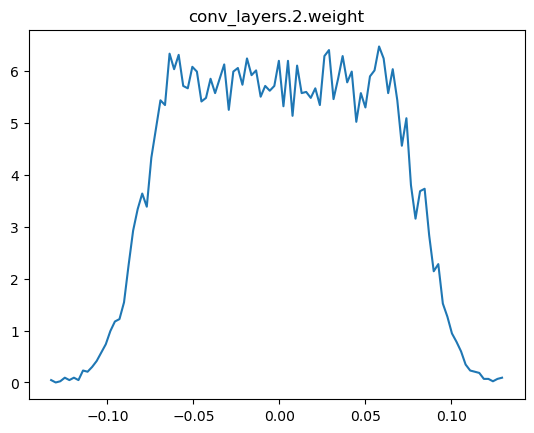

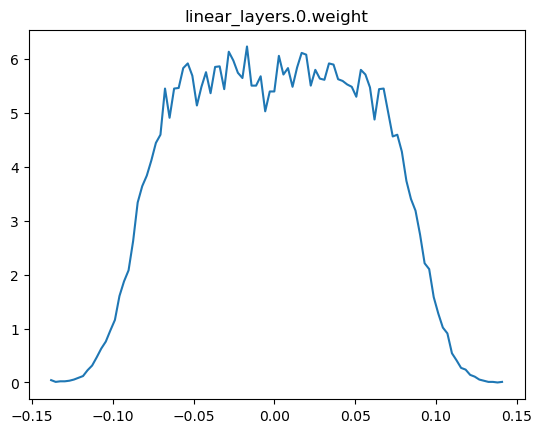

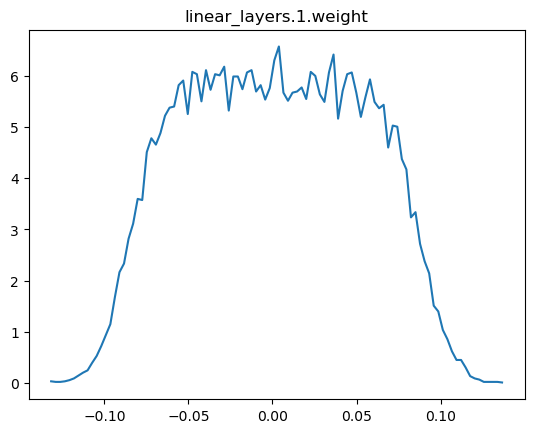

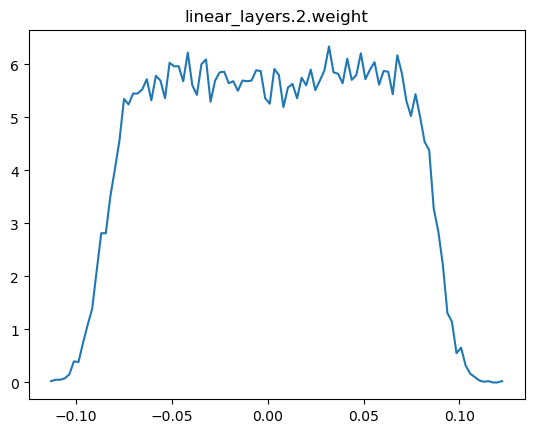

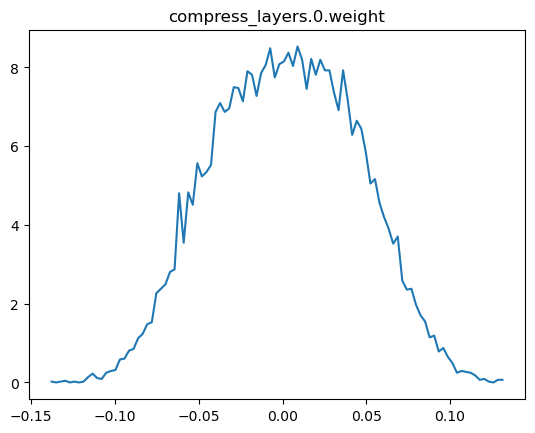

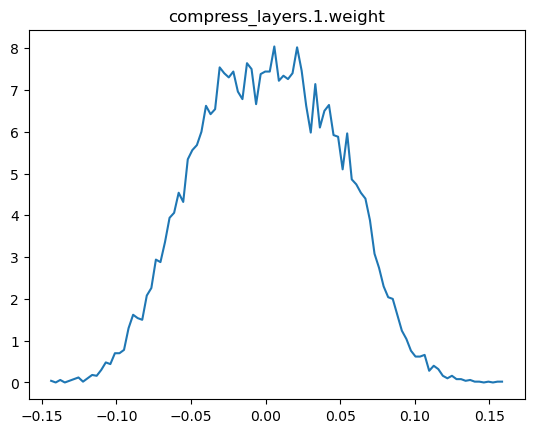

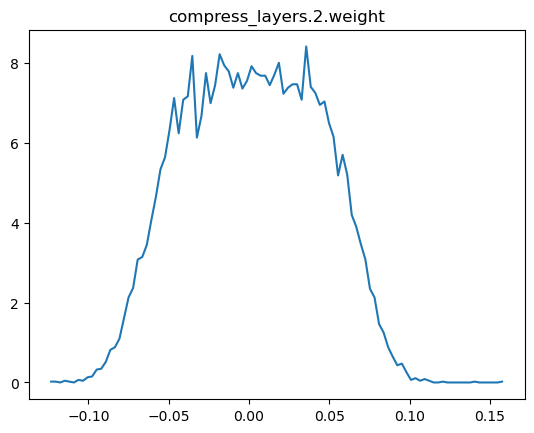

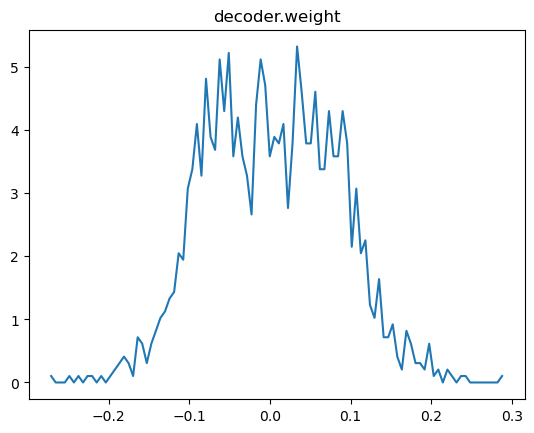

In [18]:
for n, p in model.named_parameters():
    if "norm" in n or "bias" in n:
        continue
    dy, dx = torch.histogram(p.data.cpu(), bins=100, density=True)
    gy, gx = torch.histogram(p.grad.cpu(), bins=100, density=True)
    plt.plot(dx[1:].detach(), dy.detach())
#     plt.plot(gx[1:].detach(), gy.detach())
    plt.title(n)
#     print(f"name: {n} | weight mean: {p.data.abs().mean():.3e} | weight var: {p.data.abs().std():.3e} | grad mean: {p.grad.abs().mean():.3e}")
    plt.show()